# LSTM

In [54]:
import Pkg; #Pkg.add("IterTools"); Pkg.add("Knet"); Pkg.add("Plots"); Pkg.add("CUDA"); Pkg.add("PlotlyJS")
using Knet
using Printf
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
import .Iterators: cycle, Cycle, take
using Plots; plotlyjs()
using DelimitedFiles, Statistics, Random
import CUDA
import LinearAlgebra
import Plots: heatmap
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
dataset_directory_path = "../DATA"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

In [55]:
send_message(message) = run(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d $message`);

In [56]:
function split_and_convert(string_array,splitter)
    Rlength = length(string_array)
    Clength = length(split(string_array[1],splitter))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i],splitter))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 1 method)

In [57]:
time_history = 50;

In [58]:
function data_selection(participant_directory_path)
    data_matrix = Array{Float32}(undef,0,9);
    participant_directory = readdir(participant_directory_path)
    for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
            
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            #To avoiding the colliding between subtask 3 and subtask 1
            _, remain = divrem(size(raw_data,1),time_history)
            
            #  Velocity F_fint  F_h  subtask 
            #  1        2       3      4     
            data_matrix = [data_matrix; raw_data[1:end-remain,:]]
        end
        
    return data_matrix
end

data_selection (generic function with 1 method)

In [59]:
test_data = Array{Float32}(undef,0,9);
train_data = Array{Float32}(undef,0,9);

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    
    if participant_index != 5
        data = data_selection(participant_directory_path)
        train_data = [train_data;data]
    else
        data = data_selection(participant_directory_path)
        test_data = [test_data;data]
    end
end

Sorting by Length (Descending)

In [41]:
#max_, _ = findmax(list_series)
#min_ , _ = findmin(list_series)
#mean_ = mean(list_series)
#print("Max: ",max_," Min: ", min_ ," Mean: ", mean_)
# Adding Related Time Series Length to the DATA
#assign_durations(data_array,duration_list) = for i in 1:size(data_array)[1]; data_array[i] = [data_array[i],duration_list[i]];end
##For the train_data
#assign_durations(train_data,list_series[1:length(train_data)])
##For the test_data
#assign_durations(test_data,list_series[length(train_data)+1:end])
# Sorting Data
#sort!(train_data, by = x -> x[:][2],rev=true); 
#sort!(test_data, by = x -> x[:][2],rev=true); 

In [60]:
mutable struct pHRIHelper
   measurements
   subtasks
   batchsize
   time_history
   ninstances
   shuffled
end

function data_splitter(raw_data)
    input = [raw_data[:,2] raw_data[:,3] raw_data[:,5]];
    output = raw_data[:,end];
    return input,output
end


function pHRIHelper(raw_data; batchsize = 128, time_history = 50, shuffled = true)
   measurements, subtasks = data_splitter(raw_data)
   measurement_pocket = []
   subtask_pocket = []
   needed_volume = time_history+batchsize-1;
   counter = 1;
   measurement_instance = [];
   subtask_instance = [];
   length_instance = 0;
   for i in 1:size(measurements,1)
        if counter <= needed_volume
            push!(measurement_instance,measurements[i,:])
            push!(subtask_instance,subtasks[i])
        else
           counter = 0;
           push!(measurement_pocket,measurement_instance)
           push!(subtask_pocket,subtask_instance)
           measurement_instance = [];
           subtask_instance = []; 
           length_instance +=1;
        end
        counter +=1;
   end
    if length(measurement_instance) > 1
       push!(measurement_pocket,measurement_instance)
       push!(subtask_pocket,subtask_instance) 
    end
   #ninstances, _ = divrem(length(subtasks),needed_volume)
   #ninstances = convert(Int,ninstances)
    #if length_instance == ninstances
    #    display("It Works")
    #else
    #    display(length_instance)
    #    display(ninstances)
    #end

   return pHRIHelper(measurement_pocket,subtask_pocket,batchsize,time_history,length_instance,shuffled)
end

pHRIHelper

In [61]:
#State data stands for ninstances, But every iteration it gets 50 timesteps for each batchsize element.
#Each element 
function Base.iterate(d::pHRIHelper, state=ifelse(d.shuffled, randperm(d.ninstances), 1:d.ninstances))
    length(state) < 1  && return nothing
    output = KnetArray(zeros(Int32,d.batchsize,d.time_history));            # time_steps,1
    input  = KnetArray(zeros(Float32,3,d.batchsize,d.time_history));        # X B T -> 3x16x50
    needed_volume = d.batchsize+d.time_history-2;
    raw_measurement = d.measurements[state[1]]
    size(raw_measurement,1) < needed_volume && return nothing
    related_measurements = KnetArray(zeros(Float32,size(raw_measurement,1),3))
    for i = 1:size(raw_measurement,1)
       related_measurements[i,:] = (KnetArray(raw_measurement[i]')) 
    end

    related_subtasks = convert(Array{Int32,1},d.subtasks[state[1]]);
    
    buffer = zeros(time_history,1);
    x_matrix = zeros(3,time_history);
    y_matrix = zeros(1,time_history);
    counter = 0;
    for time_step in 1:d.batchsize
        buffer = time_step:time_step+time_history-1;
        x_matrix = related_measurements[buffer,:];
        y_matrix = related_subtasks[buffer];
        input[:,time_step,:] = x_matrix';
        output[time_step,:] = y_matrix;
    end
    new_state = state[2:end]
    
    return ((input, output),new_state)    
end

In [62]:
mutable struct Linear
    w # weight
    b # bias

    function Linear(inputsize, outputsize; atype=array_type, scale::Float64=0.01)
        new(Param(convert(atype,randn(outputsize,inputsize)*scale)),Param(convert(atype,zeros(outputsize,1))))
    end
end

function (l::Linear)(x)
    return l.w*x.+l.b;
end

mutable struct Hidden
    w # weight
    b # bias
    fun # non-linear activation function like relu or tanh

    function Hidden(inputsize, outputsize, fun=relu, atype=array_type, scale=0.1)
        w = Param(convert(atype,randn(outputsize,inputsize)*scale));
        b = Param(convert(atype,zeros(outputsize,1)));
         new(w,b,fun)
    end
end

function (l::Hidden)(x)
    return l.fun.(l.w*x.+l.b);
end

In [63]:
mutable struct pHRITrainer
    hidden_input::Hidden
    rnn::RNN
    hidden::Linear
end

function pHRITrainer(input_size, hidden_size, output_size, atype=array_type)
    hidden_input = Hidden(input_size,hidden_size)
    rnn = RNN(hidden_size,hidden_size; numLayers=2,rnnType=:lstm);
    hidden = Linear(hidden_size,output_size)
    return pHRITrainer(hidden_input,rnn, hidden)
end 

function (m::pHRITrainer)(x)
    dim = size(x)
    a = m.hidden_input(reshape(x,size(x,1),:))
    b = m.rnn(reshape(a,size(a,1),dim[2],dim[3]));
    c = m.hidden(reshape(b,size(b,1),:));
    output = reshape(c,size(c,1),dim[2],dim[3]);
    return output;
end

function(m::pHRITrainer)(x,y)
    nll(model(x),y;average=true)
end

function (m::pHRITrainer)(data::pHRIHelper)
    total_loss = 0
    count = 0
    for (x,y) in data
        (loss,number) = nll(model(x),y;average=false)
        total_loss += loss
        count += number
    end
    return total_loss/count
end

In [64]:
function loss(model::pHRITrainer, data; average=true)
    total_loss = 0
    count = 0
    for (x,y) in data
        (loss,number) = nll(model(x),y;average=false)
        total_loss += loss
        count += number
    end
    average && return total_loss/count
    return total_loss, count
end

function confusions(model::pHRITrainer, data)
    ntokens = 0; ncorrect = 0
    total_ygold = Int[] ; total_ypred = Int[];
    subtasks = [1,2,3]
    for (x, ygold) in data
        scores = model(x)
        ntokens += length(ygold)
        ypred = map( y -> y[1], argmax(scores, dims=1))
        ypred = Array{Int64}(reshape(ypred,size(ypred,2),size(ypred,3)))
        ygold = Array{Int64}(ygold)
        total_ygold = [total_ygold;ygold[data.batchsize,:]]
        total_ygold = [total_ygold;ygold[1:data.batchsize-1,data.time_history]]
        total_ypred = [total_ypred;ypred[data.batchsize,:]]
        total_ypred = [total_ypred;ypred[1:data.batchsize-1,data.time_history]]
        ncorrect += sum(ygold .== ypred)
    end
        if 0 in total_ygold
            display("oa")
        end

        a = confusion_matrix(total_ygold,total_ypred, labels = subtasks)
        
        display(f1_score(a))
        display(a)
    return ncorrect / ntokens
end


confusions (generic function with 1 method)

In [65]:
function train_custom!(model, trn, dev,train_raw)
    train_loss, test_loss = Any[],Any[]
    #train_loss = [train_loss; loss(model, train_raw)];
    #test_loss = [test_loss; loss(model,dev)];
    #display(size(test_loss))
    train_error = Array{Float64,1}()
    test_error = Array{Float64,1}()
    
    bestmodel, bestloss = deepcopy(model), loss(model,dev)#test_loss[1]
    progress!(adam(model, trn), steps=2671) do y 
        test_losses = loss(model,dev)
        train_losses = loss(model, train_raw)
        train_loss = [train_loss; train_losses]
        test_loss = [test_loss; test_losses]
        push!(train_error, 1-accuracy(model,data = train_raw))
        push!(test_error, 1 -accuracy(model,data=dev))
        #display(size(test_loss))
        if test_losses < bestloss
            bestmodel, bestloss = deepcopy(model), test_losses
        end
        return (test_losses)
    end
    return bestmodel,train_loss,test_loss,train_error,test_error
end

train_custom! (generic function with 1 method)

"Model Created"

"training Started"

┣████████████████████┫ [100.00%, 212400/212400, 02:31:33/02:31:33, 23.36i/s] 0.07070208


"training Done"

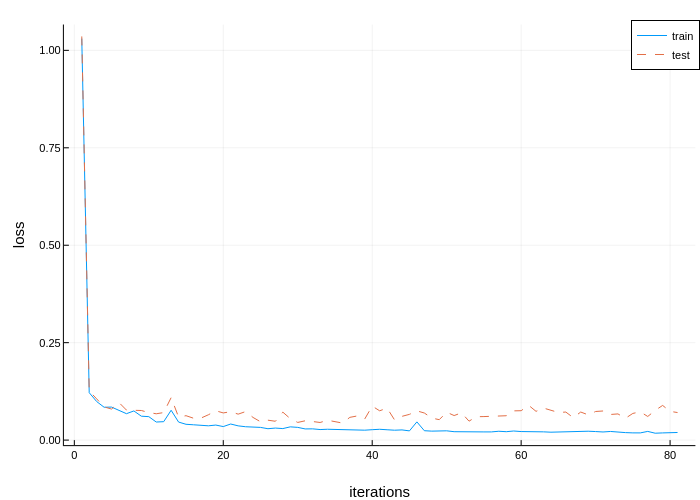

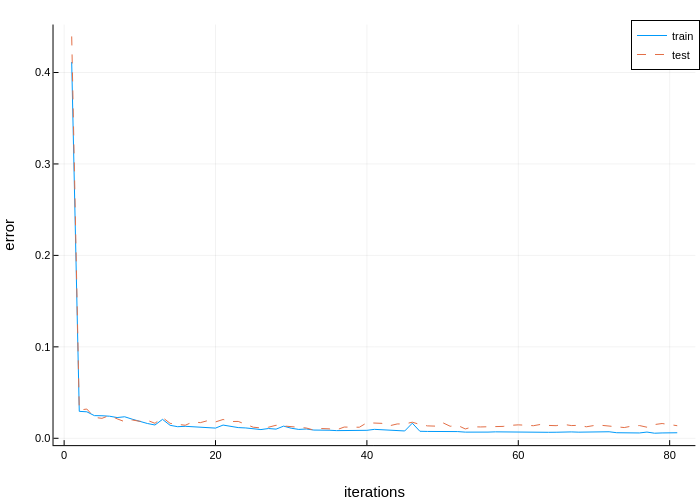

"Last Results"

Development loss = 0.04378982
Development accuracy = 0.9907491571576763
Training loss = 0.026259426
Training accuracy = 0.9916112288135593


In [66]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)
display("Model Created")
ctrn = []; epochs=80;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:81, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:81, tstloss, label="test")
error_graph = plot(1:81, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:81, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

In [68]:
confusions(model, dtst)

3-element Array{Float64,1}:
 0.9894491641545629
 0.9883134809058841
 0.9765455484759773

            Expected

      1      2      3
_____________________
  21663    369      0   │1 
     93  48331     17   │2 
      0    664  14177   │3	Predicted


0.9862286047717842

In [69]:
params(model)

5-element Array{Param,1}:
 P(KnetArray{Float32,2}(128,3))
 P(KnetArray{Float32,2}(128,1))
 P(KnetArray{Float32,3}(1,1,264192))
 P(KnetArray{Float32,2}(3,128))
 P(KnetArray{Float32,2}(3,1))

┣████████████████████┫ [100.00%, 107360/107360, 25:21/25:21, 70.57i/s] 5.966584e-12


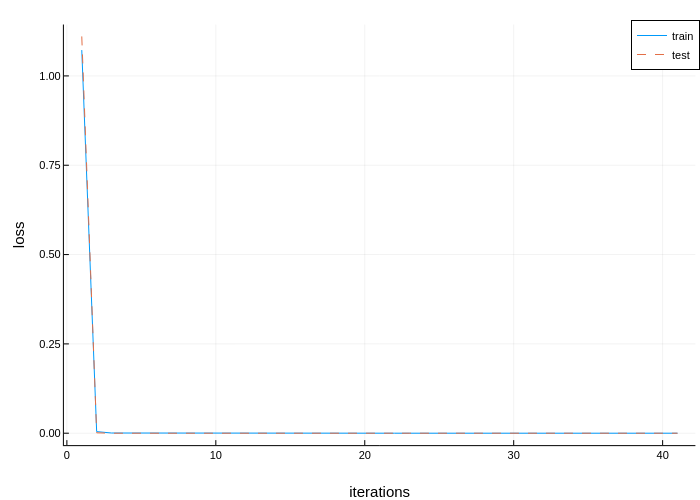

In [68]:
model,trnloss,tstloss = train!(model, trnx10, dtst,dtrn)

default(fmt=:png,ls=:auto)
plot(1:length(trnloss), trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:length(tstloss), tstloss, label="test")

#display(model(dtrn))
#display(nll(model;data=dtrn))

In [71]:
dloss = loss(model, dtst)
tloss = loss(model, dtrn)
dacc = accuracy(model, dtst)
tacc = accuracy(model, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

Development loss = 0.0
Development accuracy = 1.0
Training loss = 5.05984e-5
Training accuracy = 0.9999850968703428


"Model Created"

"training Started"

┣████████████████████┫ [100.00%, 106200/106200, 01:24:32/01:24:32, 20.94i/s] 0.07309179


"training Done"

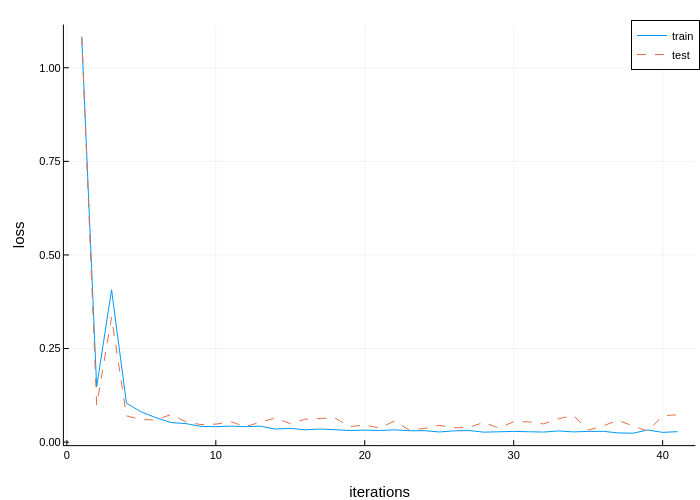

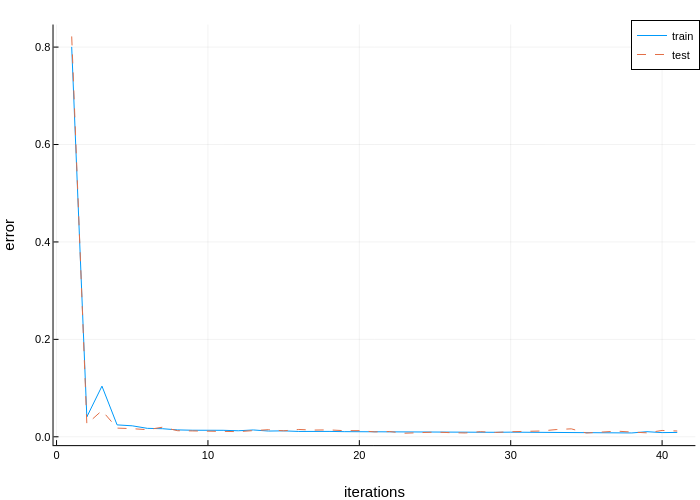

"Last Results"

Development loss = 0.029370224
Development accuracy = 0.9918805108921162
Training loss = 0.03235759
Training accuracy = 0.9895374882297552


In [28]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)
display("Model Created")
ctrn = []; epochs=40;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:41, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:41, tstloss, label="test")
error_graph = plot(1:41, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:41, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

In [53]:
confusions(model, dtst)

3-element Array{Float64,1}:
 0.9870466911011451
 0.9881204964996976
 0.9797515272153202

            Expected

      1      2      3
_____________________
  21679    353      0   │1 
    216  48202     23   │2 
      0    567  14274   │3	Predicted


0.9881292142116183

"Model Created"

"training Started"

┣████████████████████┫ [100.00%, 185850/185850, 02:29:51/02:29:51, 20.67i/s] 0.07124671


"training Done"

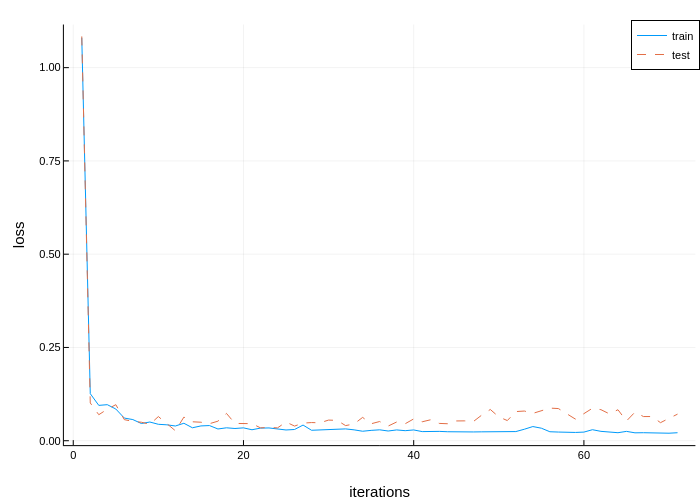

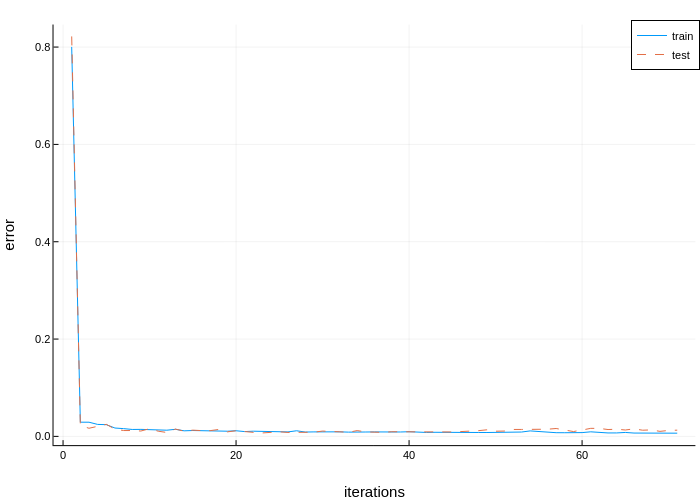

"Last Results"

Development loss = 0.026785253
Development accuracy = 0.9919654434647303
Training loss = 0.03949765
Training accuracy = 0.9872788370998117


In [55]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)
display("Model Created")
ctrn = []; epochs=70;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:71, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:71, tstloss, label="test")
error_graph = plot(1:71, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:71, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

In [30]:
dloss = loss(model, dtst)
tloss = loss(model, dtrn)
dacc = accuracy(model, dtst)
tacc = accuracy(model, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

Development loss = 0.07309179
Development accuracy = 0.9881292142116183
Training loss = 0.027983489
Training accuracy = 0.9910471986817326


"Model Created"

"training Started"

┌ Warning: nll(scores, answers::KnetArray{Int32,2} is inefficient, nll(scores, answers::Array{<:Integer}) is better.
└ @ Knet.Ops20_gpu /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20_gpu/loss.jl:8
┌ Warning: accuracy(scores, answers::KnetArray{Int32,2} is inefficient, nll(scores, answers::Array{<:Integer}) is better.
└ @ Knet.Ops20_gpu /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20_gpu/loss.jl:13
┣████████████████████┫ [100.00%, 7965/7965, 08:04/08:04, 16.44i/s] 0.08339807


"training Done"

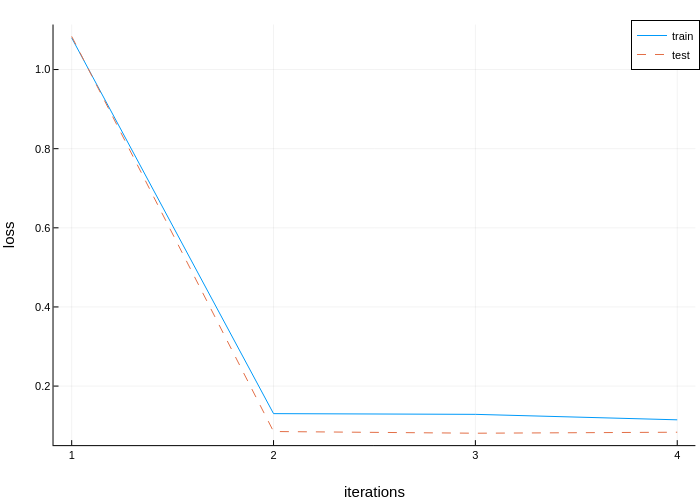

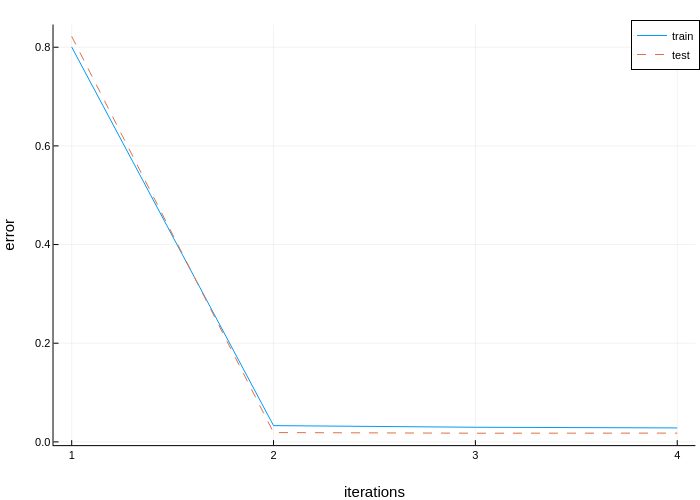

"Last Results"

┌ Warning: accuracy(model,data; o...) is deprecated, please use accuracy(model; data=data, o...)
└ @ Knet.Ops20 /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20/loss.jl:205


Development loss = 0.0808686
Development accuracy = 0.9824539678423236
Training loss = 0.12856832
Training accuracy = 0.9703555790960452


In [18]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 128, 3)
display("Model Created")
ctrn = []; epochs=3;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:4, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:4, tstloss, label="test")
error_graph = plot(1:4, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:4, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

"Model Created"

"training Started"

┣████████████████████┫ [100.00%, 13350/13350, 16:42/16:42, 13.32i/s] 0.10547353


"training Done"

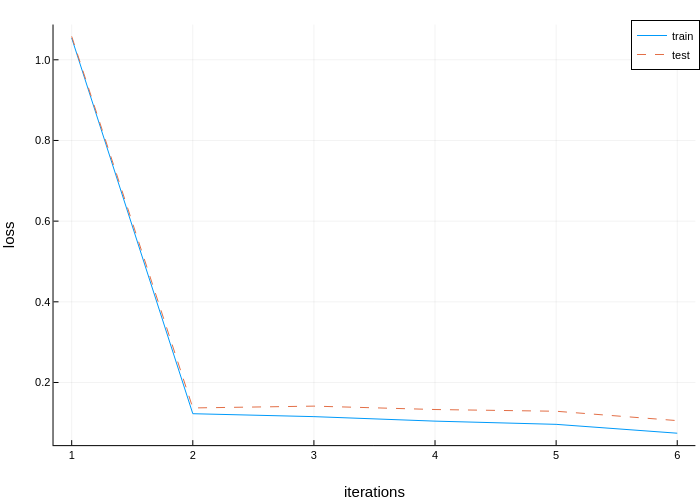

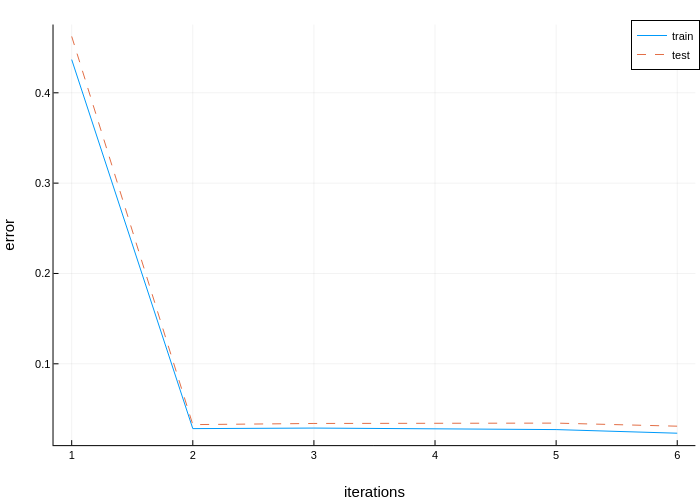

"Last Results"

Development loss = 0.10547349
Development accuracy = 0.9690523581459534
Training loss = 0.074234664
Training accuracy = 0.976835058539031


In [286]:
Random.seed!(1)
dtrn = pHRIHelper(train_data;shuffled=true);
dtst = pHRIHelper(test_data;shuffled=true);
model = pHRITrainer(3, 256, 3)
display("Model Created")
ctrn = []; epochs=5;
for b in dtrn
   push!(ctrn,b) 
end
trnx10 = collect(flatten(ctrn for i in 1:epochs));
display("training Started")
model_trained,trnloss,tstloss,trnerror,tsterror = train_custom!(model, trnx10, dtst,dtrn)
display("training Done")
default(fmt=:png,ls=:auto)
loss_graph = plot(1:6, trnloss, label="train", xlabel="iterations", ylabel="loss")
plot!(1:6, tstloss, label="test")
error_graph = plot(1:6, trnerror, label="train", xlabel="iterations", ylabel="error")
plot!(1:6, tsterror, label="test")
display(loss_graph)
display(error_graph)

display("Last Results")
dloss = loss(model_trained, dtst)
tloss = loss(model_trained, dtrn)
dacc = accuracy(model_trained, dtst)
tacc = accuracy(model_trained, dtrn)

println("Development loss = ", dloss)
println("Development accuracy = ", dacc)
println("Training loss = ", tloss)
println("Training accuracy = ", tacc)

In [48]:
confusions(model,dtst)

3-element Array{Float64,1}:
 0.9866483767718336
 0.9883347318011584
 0.9809340923119128

            Expected

      1      2      3
_____________________
  21578    454      0   │1 
    130  48293     18   │2 
      0    538  14303   │3	Predicted


0.9875100492738589

In [67]:
include("classification_metrics.jl")
export confusion_matrix, class_confusion, visualize, classification_report, condition_positive, condition_negative, predicted_positive,predicted_negative, correctly_classified, incorrectly_classified, sensitivity_score, recall_score, specificity_score, precision_score, positive_predictive_value, accuracy_score, balanced_accuracy_score, negative_predictive_value, false_negative_rate, false_positive_rate, false_discovery_rate, false_omission_rate, f1_score, prevalence_threshold, threat_score, matthews_correlation_coeff, fowlkes_mallows_index, informedness, markedness, cohen_kappa_score, hamming_loss, jaccard_score, confusion_params

In [50]:
send_message("Done!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     5    0     0  100     5      0      3  0:00:01  0:00:01 --:--:--     3

{}

100     7  100     2  100     5      1      2  0:00:02  0:00:01  0:00:01     3


Process(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d Done!`, ProcessExited(0))